In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import os

In [2]:
from sklearn.feature_extraction import text
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords

## Loading the data

In [3]:
df = pd.read_csv("data/hate_speech_data_train.csv")
df

,class,tweet
0,1,RT @__Junebugg: @VoiceOfDStreetz hell yea save...
1,2,How the hell was David Murphy's hit not a home...
2,1,RT @FeeelGreatness: You don't know where your ...
3,1,Thats some hoe shit doe
4,2,I just want vanilla Oreos
...,...,...
19821,1,RT @davegetnmoney: I beat the pussy up up up u...
19822,2,RT @RT_America: Russell Brand mocks Bill O'Rei...
19823,1,@_B_R_Y_C_E_ what happened to going fishing bi...
19824,2,RT @BriannDominguez: Gasoline - daddy Yankee &...


In [4]:
df.columns

Index(['class', 'tweet'], dtype='object')

In [5]:
mask_pickle_file='pickle/mask_pickle'
if os.path.exists(mask_pickle_file):
    file = open(mask_pickle_file,'rb')
    msk = pickle.load(file, encoding='latin1')
else:
    msk = np.random.rand(len(df)) < 0.8
    outfile = open(mask_pickle_file,'wb')
    pickle.dump(msk,outfile)
    outfile.close()

In [6]:
train = df[msk]
test = df[~msk]
print(len(train))
print(len(test))

15853
3973


In [7]:
train["class"].value_counts()

1    12315
2     2618
0      920
Name: class, dtype: int64

In [8]:
test["class"].value_counts()

1    3063
2     678
0     232
Name: class, dtype: int64

In [9]:
df = train

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


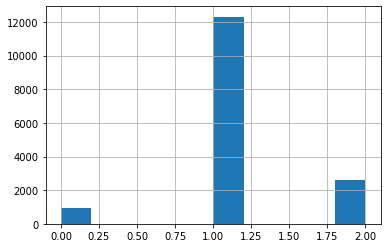

In [10]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [11]:
tweets=df.tweet

## Feature generation

In [12]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import re

#tokenize each tweet into a list; just keep useful words
#return a list in which each element denotes the list of a tweet
def cleanData(dataSet):
    '''tokenize each tweet into a list; just keep useful words;
    return a list in which each element denotes the list of each tweet'''
    tweets=dataSet
    #build tables to remove punctuations
    table = str.maketrans('', '', punctuation)
    #add and delete words from stop_words
    stop_words = stopwords.words('english')[:]
    stop_words.extend(["#ff", "ff", "rt"])
    stop_words.remove('not')
    stop_words.remove('no')
    #build lemmatizer
    lemma = nltk.wordnet.WordNetLemmatizer()
    #build dictionary to convert contractions to standard lexicons
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "cause": "because", 
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he shall",
    "he'll've": "he shall have",
    "he's": "he has",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has",
    "i'd": "I had",
    "i'd've": "I would have",
    "i'll": "I shall",
    "i'll've": "I shall have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it shall",
    "it'll've": "it shall have",
    "it's": "it has",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she shall",
    "she'll've": "she shall have",
    "she's": "she has",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that has",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there has",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they shall",
    "they'll've": "they shall have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall",
    "what'll've": "what shall have",
    "what're": "what are",
    "what's": "what has",
    "what've": "what have",
    "when's": "when has",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has",
    "where've": "where have",
    "who'll": "who shall",
    "who'll've": "who shall have",
    "who's": "who has",
    "who've": "who have",
    "why's": "why has",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you shall",
    "you'll've": "you shall have",
    "you're": "you are",
    "you've": "you have",
    "that's": "that is",
    "ya": "you",
    "im": "I am"}
    #dont; cant; cannot;
    
    cleandata = []
    
    for tweet in tweets:
        #get rid of urls
        giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        tweet = re.sub(giant_url_regex, '', tweet)
        snon1 = '&#[0-9]*;'
        tweet = re.sub(snon1, ' ', tweet)
        snon2 = '&#[0-9]*'
        tweet = re.sub(snon2, ' ', tweet)
        
        tokens = tweet.split()
        cleanstring = []
        for o in tokens:
            # change words to lowercase
            o = o.lower()
            # clean words that start as @
            if o.startswith('@'): continue
            if o.startswith(';@'): continue
            if o.startswith('"@'): continue
            #expand contractions
            o = contractions.get(o,o)
            # remove punctuation from each token
            o = o.translate(table)  
            # filter out short tokens 
            if len(o) < 2: continue
            # remove remaining tokens that are not alphabetic
            if not o.isalpha(): continue
            # filter out stop words
            if o in stop_words: continue
            # Stem and lemmatize the words
            o = lemma.lemmatize(o)
            cleanstring.append(o)
        cleandata.append(cleanstring)    
    return cleandata

def basicclean(text):
    '''for a single tweet, remove multi-space, URL, @. 
    return a string'''
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    text = re.sub(giant_url_regex, ' ', text)
    text = re.sub(mention_regex, ' ', text)
    text = re.sub(space_pattern, ' ', text)
    return text

In [13]:
#load data, clean and return line of tokens
def dataFilter_train(dataSet):
    '''clean train data
    return a list, each element denote the string of each tweet'''
    tokens = cleanData(dataSet)
    lines = []
    # filter by vocab
    for element in tokens:
        tk = ' '.join(element)
        lines.append(tk)
    return lines

In [14]:
#load data, clean and return line of tokens
def dataFilter(dataSet, vocab):
    '''clean test data; filter tokens according to vocabulary build in train; 
    return a list, each element denote the string of each tweet'''
    tokens = cleanData(dataSet)
    lines =[]
    # filter by vocab
    for element in tokens:
        tmp = [w for w in element if w in vocab]
        tk = ' '.join(tmp)
        lines.append(tk)
    return lines


In [15]:
#n-gram features for texts
def f_ngram(train, test, mode='tfidf', binary=1, ngram=(1,1), min_c=1):
    '''exact n-gram feacturs
    return: feature array (fgram); feature vocabulary (vocab)
    input: raw train and test data; ngram = (n,n) denote n_gram and ngram=(1,2) denote
    1_gram and 2_gram; tokens with count below min_c are cut off. 
    '''
    if mode == 'tfidf':
        if binary==1:
            gram = text.TfidfVectorizer(ngram_range=ngram, binary=True, min_df=min_c)
        else:
            gram = text.TfidfVectorizer(ngram_range=ngram, min_df=min_c)
        
    else: #mode=count
        if binary==1:
            gram = text.CountVectorizer(ngram_range=ngram, binary=True, min_df=min_c)
        else:
            gram = text.CountVectorizer(ngram_range=ngram, min_df=min_c)
    train = dataFilter_train(train)
    gram = gram.fit(train)
    vocab = gram.get_feature_names()
    fgram_train = gram.transform(train).toarray()
    test = dataFilter(test, vocab)
    fgram_test = gram.transform(test).toarray()
    return (fgram_train, fgram_test, vocab)

#property of words in tweets
def data_Pos(data):
    '''get property of words.
    return a list in which each element denotes the list of each tweet
    '''
    dtags = []
    for element in data:
        element = element.split()
        tag1 = nltk.pos_tag(element)
        tag = [x[1] for x in tag1]
        tagstr = " ".join(tag)
        dtags.append(tagstr)
    return dtags

def f_ngram_pos(train, test, mode='tfidf', binary=1, ngram=(1,1), min_c=1):
    '''exact n-gram feacturs based on word property information
    return: feature array (fgram); feature vocabulary (vocab)
    input: raw train and test data; ngram = (n,n), denote n_gram; 
           tokens with count below min_c are cut off. 
    '''
    if mode == 'tfidf':
        if binary==1:
            gram = text.TfidfVectorizer(ngram_range=ngram, binary=True, min_df=min_c)
        else:
            gram = text.TfidfVectorizer(ngram_range=ngram, min_df=min_c)  
    else: #mode=count
        if binary==1:
            gram = text.CountVectorizer(ngram_range=ngram, binary=True, min_df=min_c)
        else:
            gram = text.CountVectorizer(ngram_range=ngram, min_df=min_c)
    train = dataFilter_train(train)
    train_pos = data_Pos(train)
    gram.fit(train_pos)
    vocab = gram.get_feature_names()
    fgram_train = gram.transform(train_pos).toarray()
    test = dataFilter_train(test)
    test_pos = data_Pos(test)
    fgram_test = gram.transform(test_pos).toarray()
    return (fgram_train, fgram_test, vocab)

def count_twitter_objs(text):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    text = re.sub(space_pattern, ' ', text)
    text = re.sub(giant_url_regex, 'URLHERE', text)
    text = re.sub(mention_regex, 'MENTIONHERE', text)
    text = re.sub(hashtag_regex, 'HASHTAGHERE', text)
    return(text.count('URLHERE'), text.count('MENTIONHERE'), text.count('HASHTAGHERE'))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
sentiment_analyzer = sia()
def other_features(tweet):
    ''' return a list of features, including Sentiment scores, Text and Readability scores.
    input: a single tweet text
    '''
    #Sentiment scores: positive or negative
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    #text statistics
    words = basicclean(tweet) #Get text only
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = len(words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_words = len(set(words.split()))
    
    #Flesch-Kincaid grade level: measure readability of text
    FKg = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    #Flesch readability ease: measure readability of text
    Fre = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    #Count #, @, and http://
    twitter_objs = count_twitter_objs(tweet) 
    retweet = 0 #是否转发？
    if "RT " in words:
        retweet = 1
    features = [FKg, Fre, syllables, avg_syl, num_chars, num_chars_total, num_terms, 
                num_words, num_unique_words, sentiment['neg'], sentiment['pos'], sentiment['neu'], 
                sentiment['compound'], twitter_objs[2], twitter_objs[1], twitter_objs[0], retweet]
    return features

def f_others(rowdata):
    '''get other features
    return feature matrix
    input: row data
    '''
    feats=[]
    for element in rowdata:
        feats.append(other_features(element))
    return np.array(feats)

In [16]:
#draw features bases on functions
def features(train, test, ngram=(1,2), b=1, mc=5, ngram_p=None, b_p=1, mc_p=2, other_f=1, mode='tfidf'):
    '''return a tuple including features matrices for train and test 
    '''
    features_train, features_test, vocab1 = f_ngram(train, test, mode=mode, binary=b, ngram=(ngram[0],ngram[0]), min_c=mc)
    if len(ngram)>1:
        for i in range(len(ngram)-1):
            f_train, f_test, vo = f_ngram(train, test, mode=mode, binary=b, ngram=(ngram[i+1],ngram[i+1]), min_c=mc)
            features_train = np.concatenate((features_train, f_train), axis=1)
            features_test = np.concatenate((features_test, f_test), axis=1)
    if ngram_p != None:
        for i in range(len(ngram_p)):
            f_train, f_test, vo = f_ngram_pos(train, test, mode=mode, binary=b_p, ngram=(ngram_p[i],ngram_p[i]), min_c=mc_p)
            features_train = np.concatenate((features_train, f_train), axis=1)
            features_test = np.concatenate((features_test, f_test), axis=1)
    if other_f == 1:
        f_train = f_others(train)
        f_test = f_others(test)
        features_train = np.concatenate((features_train, f_train), axis=1)
        features_test = np.concatenate((features_test, f_test), axis=1)   
    return (features_train, features_test)

In [17]:
from sklearn.feature_selection import SelectFromModel
def Feature_Selection(x_train_fs, x_test_fs,Y_train_fs, c, igram, b, mode='tfidf'):
    '''The function use a logistic regression with L1 regulation to reduce the dimension-ality of the data. 
    input twitters , corresponding labels, and parameters.
    Return matrix with regularized(reduced) features '''
    features_train, features_test = features(x_train_fs, x_test_fs, ngram=(1,igram), b=b, mc=5, ngram_p=(1,1), b_p=1, mc_p=2, other_f=1, mode=mode)
    select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=c))
    X_train_fs = select.fit_transform(features_train,Y_train_fs)   
    X_test_fs = select.transform(features_test)
    return (X_train_fs, X_test_fs)

In [18]:
X_train = train.tweet
y_train = train['class'].astype(int)
X_test = test.tweet
y_test = test['class'].astype(int)

In [19]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [23]:
def build_model(X, y):
    pipe = Pipeline(
            [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                      penalty="l1", C=0.01))),
            ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])
    param_grid = [{}] # Optionally add parameters here
    grid_search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5, random_state=42).split(X, y), 
                               verbose=2)
    return grid_search

In [25]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [26]:
for n_gram in [1,2]:
    for binary in [0,1]:
        for mode in ['count', 'tfidf']:
            print('igram={0}, binary={1}, mode={2}'.format(n_gram,binary,mode))
            X_train_s, X_test_s = Feature_Selection(X_train, X_test, y_train, c=0.01, igram=n_gram, b=binary, mode=mode)
            print("feature selected")
            grid_search = build_model(X_train_s, y_train)
            model = grid_search.fit(X_train_s, y_train)
            y_preds = model.predict(X_test_s)
            report = classification_report(y_test, y_preds)
            print('igram={0}, binary={1}, mode={2}'.format(n_gram,binary,mode))
            print(report + '\n' + '-------')

igram=1, binary=0, mode=count
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   3.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.7s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s finished


igram=1, binary=0, mode=count
              precision    recall  f1-score   support

           0       0.37      0.50      0.43       232
           1       0.97      0.84      0.90      3063
           2       0.64      0.97      0.77       678

    accuracy                           0.84      3973
   macro avg       0.66      0.77      0.70      3973
weighted avg       0.88      0.84      0.85      3973

-------
igram=1, binary=0, mode=tfidf
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ................................................. , total=   4.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................
[CV] ................................................. , total=   4.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s finished


igram=1, binary=0, mode=tfidf
              precision    recall  f1-score   support

           0       0.46      0.51      0.48       232
           1       0.97      0.85      0.90      3063
           2       0.62      0.93      0.75       678

    accuracy                           0.84      3973
   macro avg       0.68      0.76      0.71      3973
weighted avg       0.88      0.84      0.85      3973

-------
igram=1, binary=1, mode=count
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ................................................. , total=   4.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished


igram=1, binary=1, mode=count
              precision    recall  f1-score   support

           0       0.37      0.52      0.43       232
           1       0.97      0.84      0.90      3063
           2       0.64      0.97      0.77       678

    accuracy                           0.84      3973
   macro avg       0.66      0.77      0.70      3973
weighted avg       0.88      0.84      0.85      3973

-------
igram=1, binary=1, mode=tfidf
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.6s finished


igram=1, binary=1, mode=tfidf
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       232
           1       0.97      0.85      0.90      3063
           2       0.63      0.94      0.75       678

    accuracy                           0.84      3973
   macro avg       0.68      0.77      0.71      3973
weighted avg       0.88      0.84      0.85      3973

-------
igram=2, binary=0, mode=count
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.8s
[CV]  ................................................................
[CV] ................................................. , total=   2.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s finished


igram=2, binary=0, mode=count
              precision    recall  f1-score   support

           0       0.37      0.50      0.43       232
           1       0.97      0.84      0.90      3063
           2       0.64      0.97      0.77       678

    accuracy                           0.84      3973
   macro avg       0.66      0.77      0.70      3973
weighted avg       0.88      0.84      0.85      3973

-------
igram=2, binary=0, mode=tfidf
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s finished


igram=2, binary=0, mode=tfidf
              precision    recall  f1-score   support

           0       0.46      0.43      0.44       232
           1       0.96      0.86      0.91      3063
           2       0.63      0.92      0.75       678

    accuracy                           0.85      3973
   macro avg       0.68      0.74      0.70      3973
weighted avg       0.87      0.85      0.85      3973

-------
igram=2, binary=1, mode=count
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................................................. , total=   3.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.0s finished


igram=2, binary=1, mode=count
              precision    recall  f1-score   support

           0       0.37      0.52      0.43       232
           1       0.97      0.84      0.90      3063
           2       0.64      0.97      0.77       678

    accuracy                           0.84      3973
   macro avg       0.66      0.77      0.70      3973
weighted avg       0.88      0.84      0.85      3973

-------
igram=2, binary=1, mode=tfidf
feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ................................................. , total=   3.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.3s finished


igram=2, binary=1, mode=tfidf
              precision    recall  f1-score   support

           0       0.45      0.44      0.45       232
           1       0.96      0.86      0.91      3063
           2       0.62      0.92      0.74       678

    accuracy                           0.85      3973
   macro avg       0.68      0.74      0.70      3973
weighted avg       0.87      0.85      0.85      3973

-------


### The Best 
> igram=2, binary=1, mode=tfidf

# Submission

In [36]:
# train
df = pd.read_csv("data/hate_speech_data_train.csv")
X_train = df.tweet
y_train = df['class'].astype(int)

In [34]:
#submission
df_submission = pd.read_csv("data/hate_speech_data_test_wo_labels.csv", sep="\t")
X_submission = df_submission.tweet

In [38]:
X_train_s, X_submission_s = Feature_Selection(X_train, X_submission, y_train, c=0.01, igram=2, b=1, mode="tfidf")
print("feature selected")
grid_search = build_model(X_train_s, y_train)
model = grid_search.fit(X_train_s, y_train)
y_preds = model.predict(X_submission_s)

feature selected
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] ................................................. , total=   7.4s
[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
[CV]  ................................................................
[CV] ................................................. , total=   6.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.9s finished


In [42]:
df_submission['class'] = y_preds

In [43]:
df_submission.head(5)

,tweet,class
0,RT @WayneL_Jr: 80% RT @NotMorris_: 60% of thes...,1
1,real nigga shit she wanna be a righteous young...,1
2,@That1guyJeff thank you. I hate you. Eat poiso...,1
3,&#128514;&#128514;&#128514; RT @A2daO: When a ...,2
4,I swear a nicca sleep but im up .. Tired as fuk!,1


In [44]:
df_submission.to_csv("submission/4_submission.csv",index=False)